In [100]:
import numpy as np

from matplotlib import pyplot as plt
from scipy import signal
import time

from pycsou.linop.conv import Convolve2D
from src.reconstruction.convolution_fft import Convolve2D_fft

## Setup

#### Generate sample signal

In [101]:
def generate_sample_signal(sig_axis_len):
    sig = np.random.rand(sig_axis_len, sig_axis_len).astype(np.float64)

    # Warm center
    warm_span = sig_axis_len // 50
    center_x = sig.shape[0] // 2
    center_y = sig.shape[1] // 2
    sig[center_x-warm_span:center_x+warm_span, center_y-warm_span:center_y+warm_span] = 1

    filter = signal.hann(sig_axis_len//2).astype(np.float64) * 100
    filter = filter[None,:] * filter[:,None]
    
    return sig, filter

In [102]:
sig, filter = generate_sample_signal(500)

In [103]:
print("Filter shape", filter.shape)

Filter shape (250, 250)


### Reference Implementation

In [104]:
ReferenceOp = Convolve2D(size=sig.size, filter=filter, shape=sig.shape)

### Proposed Implementation

In [105]:
ProposedOp = Convolve2D_fft(size=sig.size, filter=filter, shape=sig.shape)

## Tests

#### Functionality test

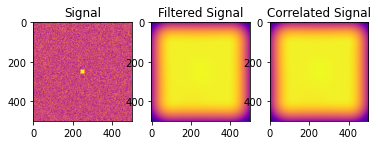

In [106]:
filtered = (ReferenceOp * sig.ravel()).reshape(sig.shape)
correlated = (ReferenceOp.H * sig.ravel()).reshape(sig.shape)

plt.figure()
plt.title("Reference")
plt.subplot(1,3,1)
plt.imshow(sig, cmap='plasma'); plt.title('Signal')
plt.subplot(1,3,2)
plt.imshow(filtered, cmap='plasma'); plt.title('Filtered Signal')
plt.subplot(1,3,3)
plt.imshow(correlated, cmap='plasma'); plt.title('Correlated Signal')
plt.show()

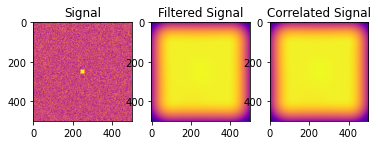

In [107]:
filtered2 = (ProposedOp * sig.ravel()).reshape(np.array(sig.shape))
correlated2 = (ProposedOp.H * sig.ravel()).reshape(sig.shape)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(sig, cmap='plasma'); plt.title('Signal')
plt.subplot(1,3,2)
plt.imshow(filtered2, cmap='plasma'); plt.title('Filtered Signal')
plt.subplot(1,3,3)
plt.imshow(correlated2, cmap='plasma'); plt.title('Correlated Signal')
plt.show()

In [108]:
# Check that the forward operator works properly
assert np.allclose(filtered, filtered2), "Wrong result of convolution"

##### Show precision-related error

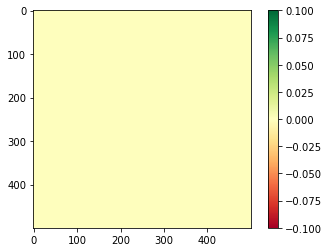

In [109]:
plt.imshow(filtered - filtered2, cmap="RdYlGn")
plt.colorbar()

In [110]:
# Check that the adjoint operator works properly
assert np.allclose(correlated, correlated2), "Wrong result of correlation"

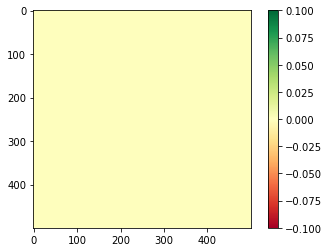

In [111]:
plt.imshow(correlated - correlated2, cmap="RdYlGn")
plt.colorbar()

### Performance test

In [112]:
# Set number of repetitions
iters_num = 500

In [113]:
ref_start_time = time.time()

for i in range(iters_num):
    t_filtered = np.reshape(ReferenceOp(sig.ravel()), np.array(sig.shape))

ref_end_time = time.time()
ref_delta_time = ref_end_time-ref_start_time

print(f"{iters_num} took {ref_delta_time} s")

500 took 11.7139732837677 s


In [114]:
prop_start_time = time.time()

for i in range(iters_num):
    t_filtered = np.reshape(ProposedOp(sig.ravel()), np.array(sig.shape))

prop_end_time = time.time()
prop_delta_time = prop_end_time-prop_start_time

print(f"{iters_num} took {prop_delta_time} s")

500 took 7.746365308761597 s


In [115]:
print(f"Increase in performances: \t {(ref_delta_time/prop_delta_time-1)*100:.2f}% \t (x{ref_delta_time/prop_delta_time:.2f} speedup)")

Increase in performances: 	 51.22% 	 (x1.51 speedup)


#### Statistics

In [116]:
def execute_test(Op, sig):
    ref_start_time = time.time()

    counter = 0
    for i in range(3):
        counter += Op(sig.ravel()).sum()

    ref_end_time = time.time()
    
    return ref_end_time-ref_start_time


In [143]:
size_steps_num = 50
reps_num = 5
(start_size, end_size) = (100, 1100)

In [144]:
np.arange(start_size, end_size, (end_size-start_size) // size_steps_num)

array([ 100,  120,  140,  160,  180,  200,  220,  240,  260,  280,  300,
        320,  340,  360,  380,  400,  420,  440,  460,  480,  500,  520,
        540,  560,  580,  600,  620,  640,  660,  680,  700,  720,  740,
        760,  780,  800,  820,  840,  860,  880,  900,  920,  940,  960,
        980, 1000, 1020, 1040, 1060, 1080])

In [145]:
ref_results = np.zeros([size_steps_num, reps_num])
prop_results = np.zeros([size_steps_num, reps_num])

for size_idx, sig_size in enumerate(np.arange(start_size, end_size, (end_size-start_size) // size_steps_num)):

    if size_idx % 2 == 0:
        print(f"Reached experiment #{size_idx}")
    
    sig, filter = generate_sample_signal(sig_size)

    ProposedOp = Convolve2D_fft(size=sig.size, filter=filter, shape=sig.shape)
    ReferenceOp = Convolve2D(size=sig.size, filter=filter, shape=sig.shape)
    for r in range(reps_num):
        prop_results[size_idx, r] = execute_test(ProposedOp, sig)
        
        time.sleep(1)
        
        ref_results[size_idx, r] = execute_test(ReferenceOp, sig)
        
        time.sleep(1)
    ReferenceOp = None
    ProposedOp = None

Reached experiment #0
Reached experiment #2
Reached experiment #4
Reached experiment #6
Reached experiment #8
Reached experiment #10
Reached experiment #12
Reached experiment #14
Reached experiment #16
Reached experiment #18
Reached experiment #20
Reached experiment #22
Reached experiment #24
Reached experiment #26
Reached experiment #28
Reached experiment #30
Reached experiment #32
Reached experiment #34
Reached experiment #36
Reached experiment #38
Reached experiment #40
Reached experiment #42
Reached experiment #44
Reached experiment #46
Reached experiment #48


In [154]:
np.savetxt("ref_results_normal.txt", ref_results)
np.savetxt("prop_results_normal.txt", prop_results)

(50,) (50, 5)


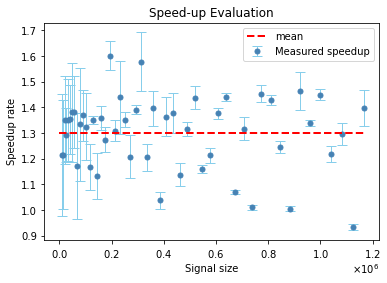

In [152]:
x_axis = np.square(np.arange(start_size, end_size, (end_size-start_size) // size_steps_num))

print(x_axis.shape, ref_results.shape)

speedup = ref_results / prop_results

plt.ticklabel_format(axis='x', style='sci', scilimits=(1, 3), useMathText=True)
std_dev = speedup.std(axis=1) 
mean_speedup = speedup.mean(axis=1) 
plt.errorbar(x_axis, mean_speedup, yerr=std_dev, label="Measured speedup", fmt="o", markersize=5, color="steelblue", ecolor="skyblue", capsize=5, elinewidth=1, markeredgewidth=1, zorder=10)
# plt.plot(x_axis, ref_results.mean(axis=1)/prop_results.mean(axis=1), label="proposed")
# plt.bar(x_axis, height=1*std_dev/mean_speedup,  width=1000, label="Coefficient of variance", align="center", color="#ffa52dbb", edgecolor="#ffa52d", zorder=9)
plt.hlines(speedup.mean(), xmin=0, xmax=[x_axis[-1]], label="mean", color="red", linestyle='--', linewidth=2, zorder=50)
plt.grid(False)
plt.xlabel("Signal size")
plt.ylabel("Speedup rate")
plt.title("Speed-up Evaluation")
plt.legend()
plt.savefig('speed_up.png', dpi = 150)

In [148]:
print("Mean speedup", speedup.mean())

Mean speedup 1.2996645593005063


### Worst case scenario

In [184]:
reps_num = 5
#List of prime numbers
range_ = np.array([71,  97, 163, 173, 457, 463, 467,  487, 643,  821, 823, 853,  877])
size_steps_num = len(range_)

In [185]:
ref_results = np.zeros([size_steps_num, reps_num])
prop_results = np.zeros([size_steps_num, reps_num])

for size_idx, sig_size in enumerate(range_):

    if size_idx % 2 == 0:
        print(f"Reached experiment #{size_idx}")
    
    sig, filter = generate_sample_signal(sig_size)

    ProposedOp = Convolve2D_fft(size=sig.size, filter=filter, shape=sig.shape)
    ReferenceOp = Convolve2D(size=sig.size, filter=filter, shape=sig.shape)
    for r in range(reps_num):
        prop_results[size_idx, r] = execute_test(ProposedOp, sig)
        
        time.sleep(1)
        
        ref_results[size_idx, r] = execute_test(ReferenceOp, sig)
        
        time.sleep(1)
    ReferenceOp = None
    ProposedOp = None

Reached experiment #0
Reached experiment #2
Reached experiment #4
Reached experiment #6
Reached experiment #8
Reached experiment #10
Reached experiment #12


(13,) (13, 5)


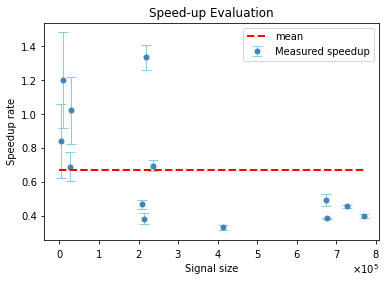

In [190]:
x_axis = np.square(range_)

print(x_axis.shape, ref_results.shape)

speedup = ref_results / prop_results

plt.ticklabel_format(axis='x', style='sci', scilimits=(1, 3), useMathText=True)
std_dev = speedup.std(axis=1) 
mean_speedup = speedup.mean(axis=1) 
plt.errorbar(x_axis, mean_speedup, yerr=std_dev, label="Measured speedup", fmt="o", markersize=5, color="steelblue", ecolor="skyblue", capsize=5, elinewidth=1, markeredgewidth=1, zorder=10)
# plt.plot(x_axis, ref_results.mean(axis=1)/prop_results.mean(axis=1), label="proposed")
# plt.bar(x_axis, height=1*std_dev/mean_speedup,  width=1000, label="Coefficient of variance", align="center", color="#ffa52dbb", edgecolor="#ffa52d", zorder=9)
plt.hlines(speedup.mean(), xmin=0, xmax=[x_axis[-1]], label="mean", color="red", linestyle='--', linewidth=2, zorder=50)
plt.grid(False)
plt.xlabel("Signal size")
plt.ylabel("Speedup rate")
plt.title("Speed-up Evaluation")
plt.legend()
plt.savefig('speed_up_worst.png', dpi = 150)

In [191]:
print("Mean speedup", speedup.mean())

Mean speedup 0.6683285622152927


In [192]:
np.savetxt("ref_results_worst.txt", ref_results)
np.savetxt("prop_results_worst.txt", prop_results)